#  First-Time Purchase Prediction

The goal of this project is to use machine learning to predict which users will make a first-time purchase based on the user's activities. Another objective is to determine which activities contribute the most in predicting whether a user will make a purchase. 

The data is pulled from raw logs and contains 4,918,677 rows and 3 columns:
- *user_id*: A hash that uniquely identifies the user
- *activity_date*: The date of the activity
- *activity_type*: The type of activity

# Loading Data and Libraries

Let's start by loading the data and importing the necessary libraries. Since the columns in the dataset do not have a header, I will manually name the columns. 

In [2]:
# Import necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Load data set 
df = pd.read_csv('activitylogs.tsv',delimiter='\t', names=['user_id', 'activity_date', 'activity_type'], encoding='utf-8')

# Exploratory Data Analysis

Exploratory data analysis (EDA) is an essential step to help us understand our data. Let's perform EDA through the following steps: 
- 1) Explore the dimensionality of our datasets
- 2) Examine unique value counts
- 3) Check for duplicate rows and missing values

In [3]:
df.shape

(4918677, 3)

Our data set has 4,918,677 rows and 3 columns

In [4]:
df.head()

,user_id,activity_date,activity_type
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


In [5]:
df.describe()

,user_id,activity_date,activity_type
count,4918677,4918677,4918677
unique,341568,671,7
top,2cd311cc3ef2d0c,2014-06-18,EmailOpen
freq,2718,50184,3191732


In [6]:
df['activity_type'].value_counts()

EmailOpen            3191732
Purchase              395031
WebVisit              384025
PageView              382263
EmailClickthrough     285568
FormSubmit            176067
CustomerSupport       103991
Name: activity_type, dtype: int64

Text(0.5, 1.0, 'Count of Activity Types')

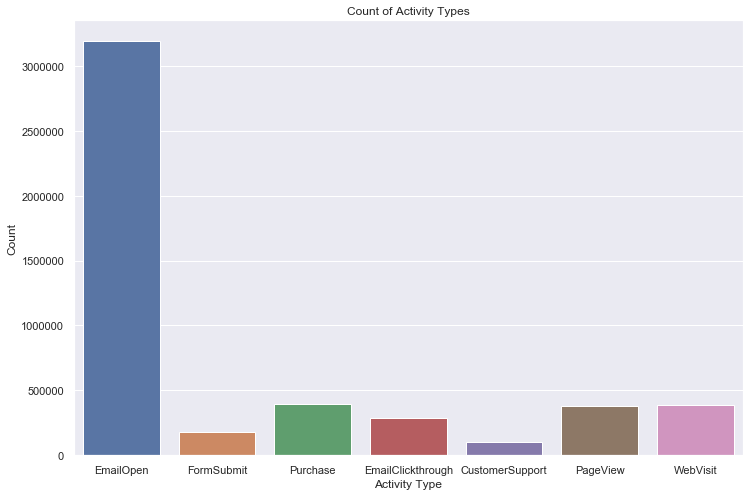

In [7]:
sns.set(rc={'figure.figsize':(12,8)})

ax = sns.countplot(x="activity_type", data=df)
ax.set(xlabel='Activity Type', ylabel='Count')
ax.set_title("Count of Activity Types")

In [8]:
print('Activity Date Start (Training Set):', df['activity_date'].min())
print('Activity Date End (Training Set):', df['activity_date'].max())

Activity Date Start (Training Set): 2013-07-01
Activity Date End (Training Set): 2015-05-02


In [9]:
# Check for duplicate rows in training set
df.duplicated().sum()

0

In [10]:
# Check for missing values 
df.isnull().sum()

user_id          0
activity_date    0
activity_type    0
dtype: int64

Let's move on to the next step since there aren't any duplicate rows or missing values.

# Data Preprocessing and Feature Engineering

The data currently isn't in a usable format for machine learning algorithms because the *activity_type* column contains several different categories. We can tidy our dataset by transposing the *activity_type* column so that each activity type will be represented as a new column. After data preprocessing is complete, we will use feature engineering to create new features.

In [11]:
activity_dummies_train = pd.get_dummies(df.activity_type, drop_first=False)
df = pd.concat([df,activity_dummies_train],axis='columns')
df.drop(['activity_type'], axis=1, inplace=True)

In [12]:
# Convert RegistrationTime to datetime object  
df['activity_date'] = pd.to_datetime(df['activity_date'])

In [13]:
df.head()

,user_id,activity_date,CustomerSupport,EmailClickthrough,EmailOpen,FormSubmit,PageView,Purchase,WebVisit
0,00002acbe042d69,2013-07-11,0,0,1,0,0,0,0
1,00002acbe042d69,2013-07-11,0,0,0,1,0,0,0
2,00002acbe042d69,2013-07-15,0,0,1,0,0,0,0
3,00002acbe042d69,2013-07-17,0,0,1,0,0,0,0
4,00002acbe042d69,2013-07-18,0,0,1,0,0,0,0


Since we are trying to predict which users will make a first-time purchase, we should only include activities from each user up until their first purchase. We can do this by dropping all the data after each user's first purchase. 

In [14]:
# Drop rows after first occurrence of purchase for each user ID  
df = df[df.groupby('user_id')['Purchase'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]

The next step is to create a new dataframe for the training and test set that has unique *user_ids* in the index. The dataframe will also contain the sum of all activity column values. We will also create a new feature called *Days* to represent the number of days between a user's first and last activity. 

In [15]:
# Sum values for all activity columns in data set
df = df.groupby('user_id').agg({'EmailOpen': lambda x: x.sum(),
                                'FormSubmit': lambda x: x.sum(),
                                'EmailClickthrough' : lambda x: x.sum(),
                                'PageView': lambda x: x.sum(),
                                'WebVisit': lambda x: x.sum(),
                                'Purchase': lambda x: x.sum(),
                                'activity_date': lambda x: (x.max() - x.min()).days})

df.rename(columns={'activity_date': 'Days'}, inplace=True)

Let's create another feature *AvgDays*. This feature represents the average number of days between each activity. 

In [16]:
# Create new feature: average days between activities  
df['TotalActivity'] = (df['EmailOpen'] + df['FormSubmit'] + df['EmailClickthrough'] + df['PageView'] + df['WebVisit'])
df['AvgDays'] = (df['Days']/df['TotalActivity'])

In [17]:
df.drop(['TotalActivity'], axis=1, inplace=True)

In [18]:
df.fillna(0, inplace=True)

In [19]:
df.head()

,EmailOpen,FormSubmit,EmailClickthrough,PageView,WebVisit,Purchase,Days,AvgDays
user_id,,,,,,,,
00002acbe042d69,9,1,0,0,0,0,32,3.20
0000a3a34bd07e6,20,0,0,0,0,0,583,29.15
0000ecf58c94668,0,0,0,0,0,1,0,0.00
00012205dd4613b,2,0,0,0,0,0,28,14.00
000198d39a568cf,0,0,0,0,0,1,0,0.00


Let's take a quick look at the activities associated with users who made a purchase.

In [20]:
df.sort_values(by=['Purchase'], ascending=False).head(20)

,EmailOpen,FormSubmit,EmailClickthrough,PageView,WebVisit,Purchase,Days,AvgDays
user_id,,,,,,,,
44969c83458e41f,0,0,0,0,0,1,0,0.000000
bf9b20a025d5082,0,0,0,0,0,1,0,0.000000
4d18598bb8f3bf2,1,0,0,0,0,1,0,0.000000
bf99551925665cf,0,0,0,0,0,1,0,0.000000
bf9964284e710fc,1,0,0,0,0,1,21,21.000000
bf997a5dfe51dec,3,0,0,0,0,1,26,8.666667
4d1730fb7ccac07,0,0,0,0,0,1,0,0.000000
4d172859b898453,0,0,0,0,0,1,0,0.000000
bf99ae766f56ff8,1,0,0,0,0,1,52,52.000000


From these 20 rows of data, it appears that there might be a negative correlation between activity and purchase. It appears that a majority of users who made a purchase did not engage in any activities. 

In [21]:
# create an index of users who purchased an item but did not engage in any other activities
indexNames = df[((df.EmailOpen == 0) & (df.FormSubmit == 0) & (df.EmailClickthrough == 0) & (df.PageView == 0) 
                & (df.WebVisit == 0) & (df.Purchase == 1))].index

In [22]:
len(indexNames)

78111

In [23]:
df['Purchase'].value_counts()

0    237577
1    103991
Name: Purchase, dtype: int64

Surprisingly, roughly 75% of users who made a purchase did not engage in any other activities. These conversions are attributed to an unknown source. Perhaps they were led to the product through an advertisement or affiliate marketing link. 

Let's also take a quick look at individuals who didn't make a purchase.

In [24]:
df.sort_values(by=['Purchase'], ascending=True).head(20)

,EmailOpen,FormSubmit,EmailClickthrough,PageView,WebVisit,Purchase,Days,AvgDays
user_id,,,,,,,,
00002acbe042d69,9,1,0,0,0,0,32,3.200000
939eb07725d72b2,2,0,0,0,0,0,1,0.500000
939ee55a577574a,43,1,2,0,0,0,635,13.804348
939f176b0dd5a5b,1,0,0,0,0,0,0,0.000000
939f5c755a883a8,0,1,0,0,0,0,0,0.000000
939fafe7831ecfd,9,3,11,8,8,0,598,15.333333
93a00bbf6e54940,10,0,0,0,0,0,345,34.500000
93a055ffd6d3a61,3,0,0,0,0,0,112,37.333333
93a092f40404a39,4,0,0,0,0,0,100,25.000000


It looks like users who didn't make a purchase engaged in more activities than users who made a purchase. Thus, should be a negative correlation between user activities and making a purchase. Out of all the activity types, the strongest negative correlation appears to exist between *EmailOpen* and *Purchase*. 

# Correlation Matrix

Let's create a correlation matrix to understand which activity types are associated with purchase. 

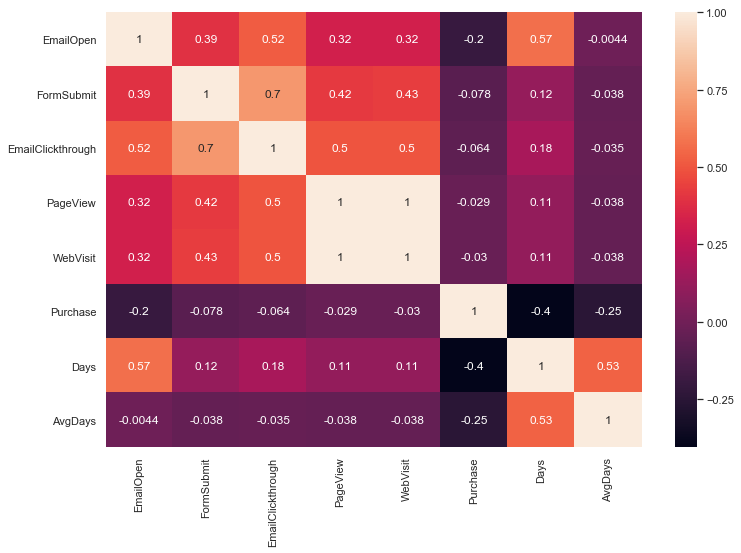

In [25]:
plt.figure(figsize = (12, 8))
features_corr = df.corr()
sns.heatmap(features_corr, annot = True)
plt.show()

The correlation matrix reveals that *Days*, *AvgDays*, and *EmailOpen* have the strongest negative correlation with *Purchase*. *EmailClickthrough* and *FormSubmit* have a weak negative correlation with *Purchase*. Lastly, *PageView* and *WebVisit* have a very weak negative correlation with *Purchase*.

Later, we will use the *feature importance* method of XGBoost, Random Forest and CatBoost to tell us how important each feature is for constructing the model.

# Data Visualization

Let's visualize the distribution of the data for users who made a purchase versus users who did not make a purchase using a histogram. 

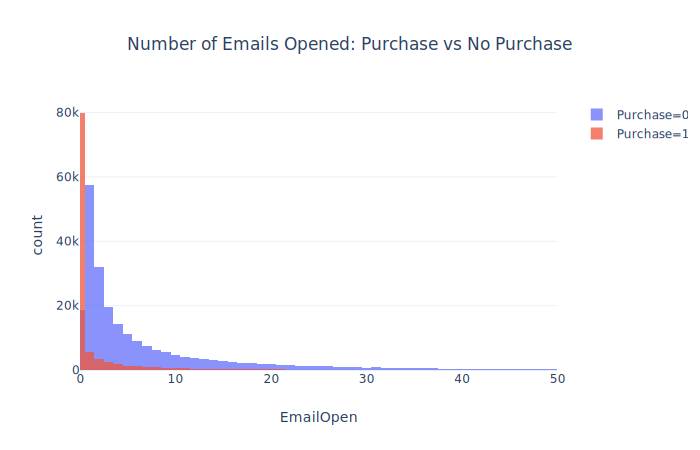

In [36]:
import plotly.express as px
fig = px.histogram(df, x="EmailOpen", color="Purchase", title='Number of Emails Opened: Purchase vs No Purchase',
                   template='plotly_white',hover_data=df.columns).update(layout=dict(title=dict(x=0.5)))
fig.update_xaxes(range=[0, 50])
# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show("svg")

We can see that users who didn't make a purchase have a much higher count of opened emails than users who made a purchase. In fact, a majority of users who made purchases didn't open emails. 

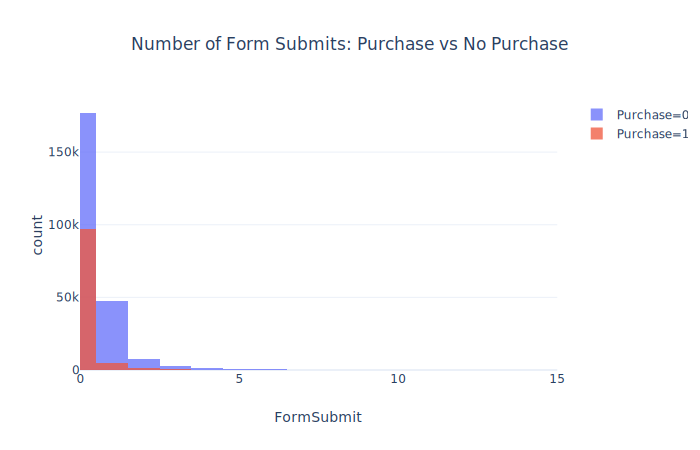

In [37]:
import plotly.express as px
fig = px.histogram(df, x="FormSubmit", color="Purchase", title='Number of Form Submits: Purchase vs No Purchase',
                   template='plotly_white',hover_data=df.columns).update(layout=dict(title=dict(x=0.5)))
fig.update_xaxes(range=[0, 15])
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show("svg")

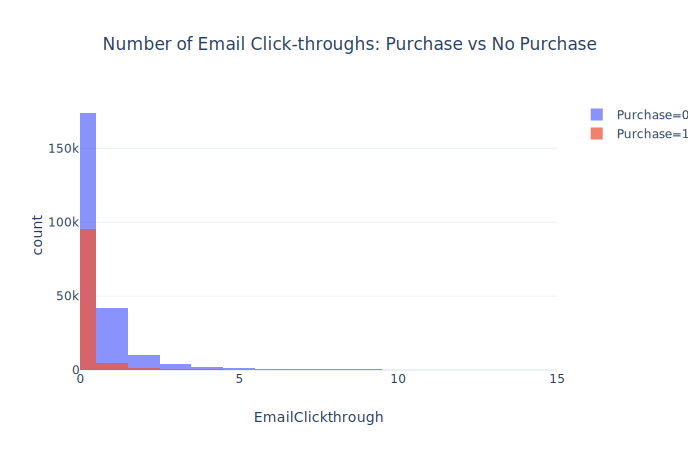

In [38]:
import plotly.express as px
fig = px.histogram(df, x="EmailClickthrough", color="Purchase", title='Number of Email Click-throughs: Purchase vs No Purchase',
                   template='plotly_white',hover_data=df.columns).update(layout=dict(title=dict(x=0.5)))
fig.update_xaxes(range=[0, 15])
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show("svg")

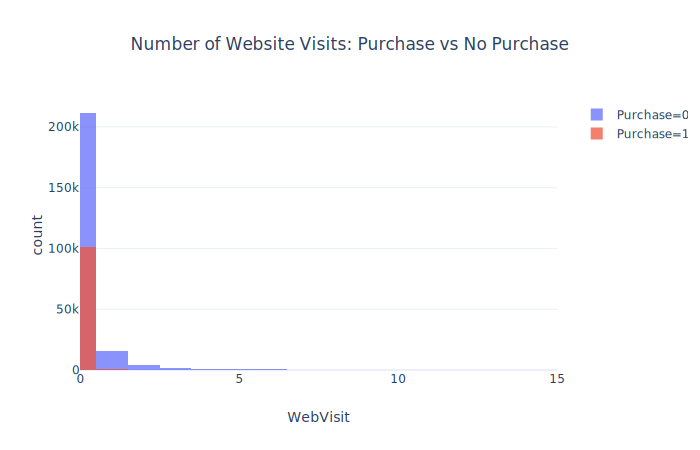

In [39]:
import plotly.express as px
fig = px.histogram(df, x="WebVisit", color="Purchase", title='Number of Website Visits: Purchase vs No Purchase',
                   template='plotly_white',hover_data=df.columns).update(layout=dict(title=dict(x=0.5)))
fig.update_xaxes(range=[0, 15])
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show("svg")

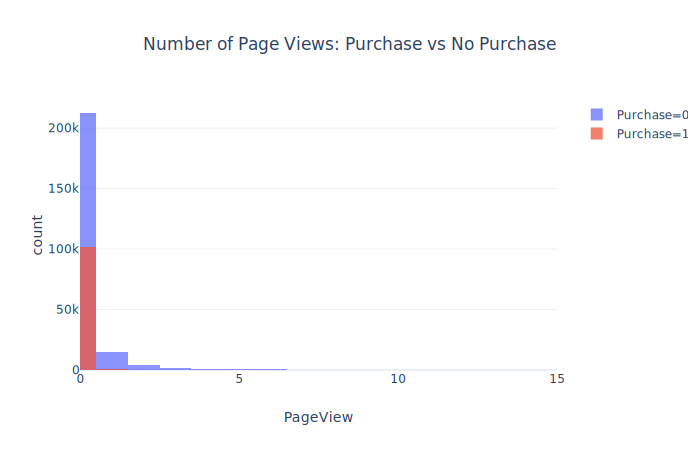

In [40]:
import plotly.express as px
fig = px.histogram(df, x="PageView", color="Purchase", title='Number of Page Views: Purchase vs No Purchase',
                   template='plotly_white',hover_data=df.columns).update(layout=dict(title=dict(x=0.5)))
fig.update_xaxes(range=[0, 15])
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show("svg")

The rest of the histograms show that the vast majority of users who made a purchase did not engage in other activities such as submitting forms, email click-throughs, website visits, and page views. 

# Machine Learning Model Development and Evaluation

Let's develop machine learning classification models using logistic regression, XGBoost, random forest, and CatBoost. Logistic regression serves as a baseline model for comparison. Models are evaluated using cross-validation. 75% of the training data is set aside to train the model and 25% is allocated to the test set.  

In [30]:
# Import necessary libraries
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

#Split into training and holdout sets 
X = df.drop('Purchase', axis=1)
y = df['Purchase']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.25, random_state=0)

In [31]:
# Basline Model: Logistic Regression 
scaler = StandardScaler() # Need to standardize data for logistic regression 
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

logreg = LogisticRegression(random_state=0, solver='lbfgs')

logreg.fit(X_train,y_train)
logreg_pred = logreg.predict(X_test)

print("Logistic Regression - Testing Accuracy:", (round(accuracy_score(y_test, logreg_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test, logreg_pred))

Logistic Regression - Testing Accuracy: 0.69


[[58448   852]
 [25910   182]]


              precision    recall  f1-score   support

           0       0.69      0.99      0.81     59300
           1       0.18      0.01      0.01     26092

   micro avg       0.69      0.69      0.69     85392
   macro avg       0.43      0.50      0.41     85392
weighted avg       0.53      0.69      0.57     85392



AUC Score: 0.49630384792273496


Our baseline model, logistic regression, has very poor accuracy. AUC Scores range from 0.5 (no better accuracy than chance) to 1.0 (perfect classifier). An AUC Score of 0.5 means our logistic regression model cannot separate the classes. This poor performance may be a result of having imbalanced classes since the number of people who made a purchase are significantly less than people who didn't make a purchase. Let's resolve this problem by balancing the ratio of the negative class to the positive class.  

In [32]:
# Basline Model: Logistic Regression - Balanced class weights 
scaler = StandardScaler() 
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

logreg = LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced') 

logreg.fit(X_train,y_train)
logreg_pred = logreg.predict(X_test)

print("Logistic Regression - Testing Accuracy:", (round(accuracy_score(y_test, logreg_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test, logreg_pred))

Logistic Regression - Testing Accuracy: 0.66


[[33193 26107]
 [ 2905 23187]]


              precision    recall  f1-score   support

           0       0.92      0.56      0.70     59300
           1       0.47      0.89      0.62     26092

   micro avg       0.66      0.66      0.66     85392
   macro avg       0.69      0.72      0.66     85392
weighted avg       0.78      0.66      0.67     85392



AUC Score: 0.7242051203434003


The model's performance is significantly better after balancing the ratio of the negative class to the positive class. I will also balance the class weights for my other machine learning models. Let's see if we can do better with XGBoost, Random Forest, and CatBoost.

In [33]:
# XGBoost 
weights = (y==0).sum()/(1.0 *  (y==1).sum())
xgb = XGBClassifier(silent=True,
                      random_state=1, 
                      scale_pos_weight=weights,
                      learning_rate=0.04,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=2000, 
                      reg_alpha = 0.3,
                      max_depth=4,
                      n_jobs = -1,
                      gamma=10)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("XGBoost - Testing Accuracy:", (round(accuracy_score(y_test, xgb_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, xgb_pred))
print('\n')
print(classification_report(y_test, xgb_pred))
print('\n')
print("ROC AUC Score:", roc_auc_score(y_test,xgb_pred))

XGBoost - Testing Accuracy: 0.94


[[57757  1543]
 [ 3490 22602]]


              precision    recall  f1-score   support

           0       0.94      0.97      0.96     59300
           1       0.94      0.87      0.90     26092

   micro avg       0.94      0.94      0.94     85392
   macro avg       0.94      0.92      0.93     85392
weighted avg       0.94      0.94      0.94     85392



ROC AUC Score: 0.9201111451785989


XGBoost outperforms logistic regression by a wide margin with an AUC of 0.92. 

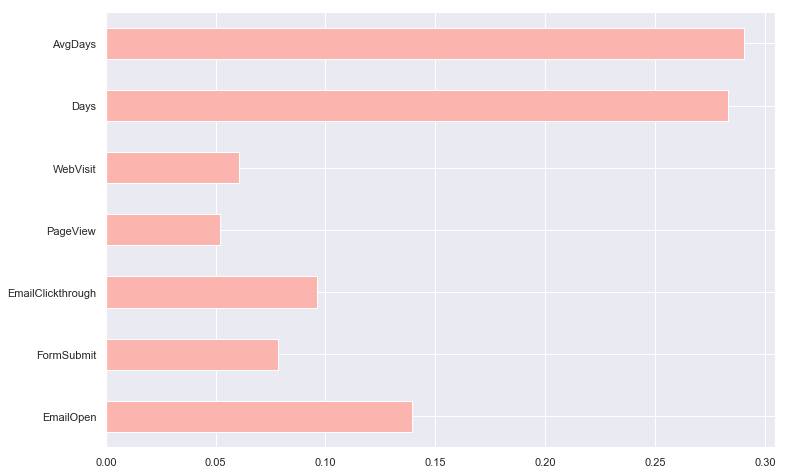

In [34]:
#XGBoost Feature Importance
(pd.Series(xgb.feature_importances_, index=X.columns)
   .plot(kind='barh', colormap = 'Pastel1'))  

The most important feature in the model is *AvgDays* (average number of days between activities) followed by *Days* (days between first and last activity) and *EmailOpen*. *EmailOpen* is the most important activity type followed by *EmailClickthrough* and *FormSubmit*. 

Next, let's see how random forest performs compares to XGBoost.  

In [35]:
#Random Forest - Tuned Parameters 
rfc = RandomForestClassifier(random_state=1,
                             class_weight='balanced',
                             n_jobs = -1,
                             n_estimators=1000,
                             max_depth=10,
                             min_samples_split=2,
                             min_samples_leaf=2,
                             max_features='auto',
                             criterion='gini',
                             bootstrap=True
                             )

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
                
print("Random Forest - Testing Accuracy:", (round(accuracy_score(y_test, rfc_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, rfc_pred))
print('\n')
print(classification_report(y_test, rfc_pred))
print('\n')
print("AUC Score:", roc_auc_score(y_test,rfc_pred))

Random Forest - Testing Accuracy: 0.81


[[47141 12159]
 [ 3700 22392]]


              precision    recall  f1-score   support

           0       0.93      0.79      0.86     59300
           1       0.65      0.86      0.74     26092

   micro avg       0.81      0.81      0.81     85392
   macro avg       0.79      0.83      0.80     85392
weighted avg       0.84      0.81      0.82     85392



AUC Score: 0.8265759619806837


Our random forest model has lower accuracy than my XGBoost model.

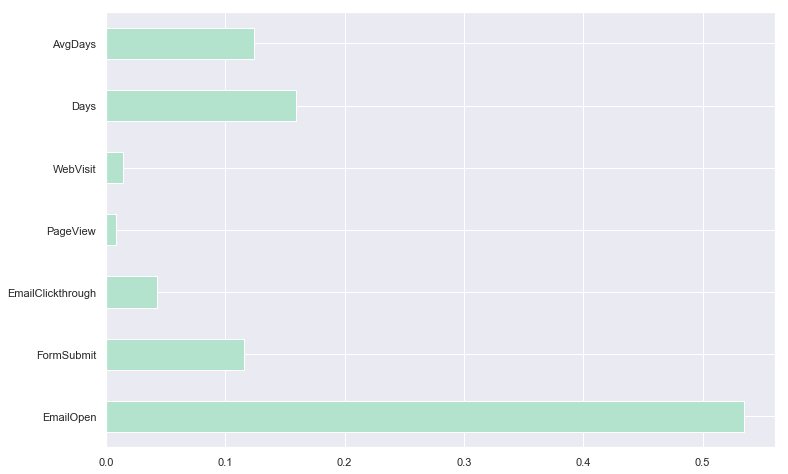

In [36]:
#Random Forest Feature Importance
(pd.Series(rfc.feature_importances_, index=X.columns)
   .plot(kind='barh', colormap = 'Pastel2')) 

Feature importance of random forest reveals that the top three features are *EmailOpen*, *Days* (days between first and last activity), and *AvgDays* (average number of days between activities). Random forest places significantly more importance on *EmailOpen* than XGBoost. However, I trust the feature importance from XGBoost more since the model a higher AUC score. 

*EmailOpen* is the most important activity type followed by *FormSubmit* and *EmailClickthrough*. 

In [37]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations=1000,
                        learning_rate=0.03,
                        depth=6,
                        bagging_temperature=1,
                        task_type="GPU")

cb.fit(X_train, y_train, verbose=False)
cb_pred = cb.predict(X_test)

print("CatBoost - Testing Accuracy:", (round(accuracy_score(y_test, cb_pred.round(0)), 2)))
print('\n')
print(confusion_matrix(y_test, cb_pred))
print('\n')
print(classification_report(y_test, cb_pred))
print('\n')
print("ROC AUC Score:", roc_auc_score(y_test,cb_pred))

CatBoost - Testing Accuracy: 0.95


[[58916   384]
 [ 4186 21906]]


              precision    recall  f1-score   support

           0       0.93      0.99      0.96     59300
           1       0.98      0.84      0.91     26092

   micro avg       0.95      0.95      0.95     85392
   macro avg       0.96      0.92      0.93     85392
weighted avg       0.95      0.95      0.95     85392



ROC AUC Score: 0.9165460677602331


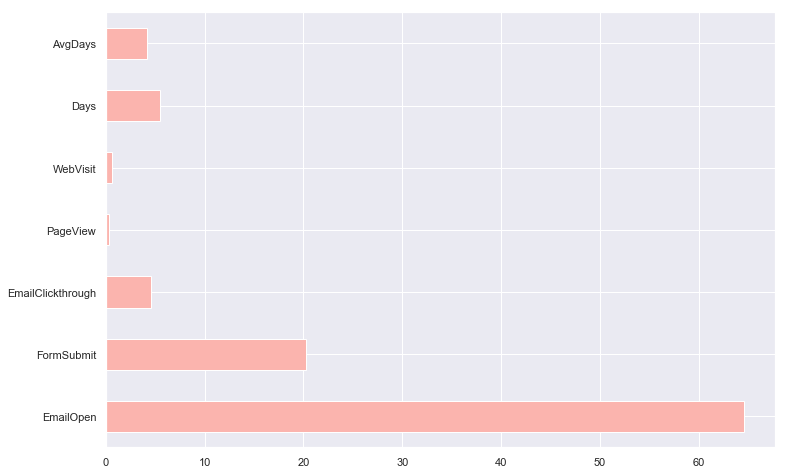

In [38]:
# CatBoost Feature Importance
(pd.Series(cb.feature_importances_, index=X.columns)
   .plot(kind='barh', colormap = 'Pastel1')) 

CatBoost has slightly lower accuracy than XGBoost. The top three features are *EmailOpen*, *FormSubmit*, and *Days* (days between first and last activity). CatBoost places significantly more weight on *EmailOpen* than all the other features. 

**Conclusion**: In conclusion, feature importance from XGBoost, random forest, and CatBoost reveals that *EmailOpen* is the most important activity type for predicting first-time user purchases. There is a negative assocation between all these variables and first-time purchases. The second and third most important activity types for predicting first-time user purchases are *FormSubmit* and *EmailClickthrough*. We can be confident that my XGBoost model is accurate because I evaluated it using cross-validation and obtained an AUC score of 0.92.

**Business Implications**: These results suggest that 75% of conversions are attributed to an unknown source. For the next step, this company should determine the source of these conversions. If it turns out that a majority of these conversions come from advertisement, this company can greatly benefit from creating a multi-touch attribution model. This type of model will reveal which advertisements and marketing channels contribute the most to conversions. 